In [28]:
import pandas as pd
import numpy as np
from os import path
from CSVUtils import *
import ta
import matplotlib.pyplot as plt
import seaborn as sn
from pprint import pprint

# Import required libraries
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

In [29]:
DIR = "./input/yahoo"
nameList = ["^GSPC", "^GDAXI", "^HSI"]
df_list = []

trainStartDate = pd.to_datetime("2000-01-01")
trainEndDate = pd.to_datetime("2014-12-31")
testStartDate = pd.to_datetime("2015-01-01")
testEndDate = pd.to_datetime("2019-12-31")

startDate = trainStartDate
endDate = testEndDate

# for name in nameList:
name = nameList[0]
df = csv2df(csv_path=DIR, csv_name=name+".csv", source="yahoo")
df = df.dropna()
df_list.append(df)

In [30]:
intersect_dates = df_list[0]['Date']
for df in df_list[1:]:
    df.dropna(inplace = True)
    intersect_dates = np.intersect1d(intersect_dates, df['Date'])
# Remove all NAN in the df

for i, df in enumerate(df_list):
    df.dropna(inplace = True)
    df = df[df['Date'].isin(intersect_dates)].reset_index(drop=True)
    df = df[(df['Date'] >= startDate) & (df['Date'] <= endDate)]
    df_list[i] = df.reset_index(drop=True)

In [31]:
# df = df_list[0]
df['trend_macd'] = ta.trend.macd(df['Price'])
df['trend_macd_diff'] = ta.trend.macd_diff(df['Price'])
df['trend_macd_signal'] = ta.trend.macd_signal(df['Price'])
df['ma30'] = rolling_mean = df.Price.rolling(window=30).mean()
df['ma60'] = rolling_mean = df.Price.rolling(window=60).mean()

In [32]:
df.dropna(inplace = True)
df = df[df['Date'].isin(intersect_dates)].reset_index(drop=True)
df = df[(df['Date'] >= startDate) & (df['Date'] <= endDate)]
df = df.reset_index(drop=True)

In [33]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

col_names = ['ma60', 'ma30']
signal_col_suffix = '_signal'
future_col_suffic = ['_futurePeak', '_futureTrough']
for i,x in enumerate([df.ma60, df.ma30]):
    x = (x/x[0]).reset_index(drop = True)
    
    peaks, pp = find_peaks(x, prominence=0.001)
    troughs, tp = find_peaks(-1*x, prominence=0.001)
    
    isin_peaks = np.isin(df.index.values, peaks).astype(int)
    isin_troughs = np.isin(df.index.values, troughs).astype(int) * -1
    df[col_names[i]+signal_col_suffix] = isin_peaks+isin_troughs
    
    df[col_names[i]+future_col_suffic[0]] = [int(1 in isin_peaks[i+1:i+31]) for i in df.index.values]
    df[col_names[i]+future_col_suffic[1]] = [int(1 in isin_troughs[i+1:i+31]) for i in df.index.values]

In [56]:
future_cols = ['ma60_signal', 'ma60_futurePeak', 'ma60_futureTrough', 'ma30_signal', "ma30_futurePeak", "ma30_futureTrough"]
target_cols = ["ma60_futurePeak", "ma60_futureTrough", 'ma30_futurePeak', 'ma30_futureTrough']
price_cols = ['Open', 'High', 'Low', 'Price', 'Vol', 'ma30', 'ma60']

# feature_cols = [col for col in list(df.columns) if col not in future_cols+['Date']]
feature_cols = ['trend_macd', 'trend_macd_diff', 'trend_macd_signal', 'ma30', 'ma60']

In [35]:
df_backup = df.copy()
df[price_cols] = df[price_cols]/df['Price'][0]
df[price_cols] = df[price_cols].replace([np.inf, -np.inf], np.nan)
df['Vol'] = df['Vol']/df['Vol'][0]
df[price_cols] = df[price_cols].fillna(0)

df['Date'] = pd.to_datetime(df['Date'])

In [52]:
df

,Date,Open,High,Low,Price,Vol,Change,trend_macd,trend_macd_diff,trend_macd_signal,ma30,ma60,ma60_signal,ma60_futurePeak,ma60_futureTrough,ma30_signal,ma30_futurePeak,ma30_futureTrough
0,2000-03-28,1.010698,1.013020,0.999576,1.000000,1.000000,-0.010585,34.522829,12.528714,21.994115,0.935492,0.939216,0,1,0,0,1,0
1,2000-03-29,1.000000,1.009100,0.993182,1.000524,1.107184,0.000524,34.475477,9.985090,24.490387,0.937845,0.939805,0,1,0,0,1,0
2,2000-03-30,1.000524,1.006400,0.978046,0.986861,1.244292,-0.013656,32.402192,6.329444,26.072748,0.940062,0.940784,0,1,0,0,1,0
3,2000-03-31,0.986861,1.008012,0.984513,0.993931,1.279741,0.007164,31.258931,4.148947,27.109985,0.942501,0.941850,0,1,0,0,1,0
4,2000-04-03,0.993931,0.999642,0.986224,0.998833,1.065270,0.004931,30.596504,2.789215,27.807289,0.946035,0.942983,0,1,0,0,1,0
5,2000-04-04,0.998839,1.012416,0.939432,0.991378,1.580085,-0.007464,28.832192,0.819923,28.012269,0.949187,0.943572,0,1,0,0,1,0
6,2000-04-05,0.991378,0.999217,0.980315,0.986496,1.157648,-0.004924,26.534204,-1.182453,27.716656,0.951988,0.943901,0,1,0,0,1,0
7,2000-04-06,0.986496,1.002673,0.986496,0.995762,1.050985,0.009392,25.545815,-1.736673,27.282488,0.955258,0.944595,0,1,0,0,1,0
8,2000-04-07,0.995762,1.007263,0.995762,1.005717,0.929622,0.009998,25.677695,-1.283834,26.961530,0.959304,0.945525,0,1,0,0,1,0
9,2000-04-10,1.005717,1.012907,0.997095,0.997831,0.890105,-0.007841,24.539906,-1.937299,26.477205,0.962761,0.946130,0,1,0,0,1,0


In [36]:
train_df = df[(df['Date'] >= trainStartDate) & (df['Date'] <= trainEndDate)]
test_df = df[(df['Date'] >= testStartDate) & (df['Date'] <= testEndDate)]

In [57]:
X_train = train_df[feature_cols].values
y_train = train_df[target_cols[0]].values

X_test = test_df[feature_cols].values
y_test = test_df[target_cols[0]].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=5000)
# mlp = MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)

mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_train,predict_train))
print('\n\n')
print(classification_report(y_train,predict_train))

(3714, 5)
(1257, 5)
[[2962    3]
 [ 748    1]]



              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2965
           1       0.25      0.00      0.00       749

    accuracy                           0.80      3714
   macro avg       0.52      0.50      0.45      3714
weighted avg       0.69      0.80      0.71      3714



In [58]:
print(y_train[:30])
print(predict_train[:30])

[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [59]:
print(y_test[:30])
print(predict_test[:30])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [60]:
X_train = train_df[feature_cols].values
y_train = train_df[target_cols[2]].values

X_test = test_df[feature_cols].values
y_test = test_df[target_cols[2]].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

# mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
mlp = MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=5000)

mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

print(np.sqrt(mean_squared_error(y_train,predict_train)))
print(np.sqrt(mean_squared_error(y_test,predict_test))) 

(3714, 5)
(1257, 5)
0.4584502635217716
0.5276801882871849


In [64]:
from sklearn.linear_model import LinearRegression

X_train = train_df[feature_cols].values
y_train = train_df[target_cols[2]].values

X_test = test_df[feature_cols].values
y_test = test_df[target_cols[2]].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

# mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
reg = LinearRegression()

reg.fit(X_train,y_train)

predict_train = reg.predict(X_train)
predict_test = reg.predict(X_test)

print(np.sqrt(mean_squared_error(y_train,predict_train)))
print(np.sqrt(mean_squared_error(y_test,predict_test))) 

(3714, 5)
(1257, 5)
0.4722093154541487
0.5681720206124125


In [65]:
result_df = pd.DataFrame({'Name':train_df[feature_cols].columns, 'Value': reg.coef_})
result_df['Abs'] = np.absolute(result_df['Value'])

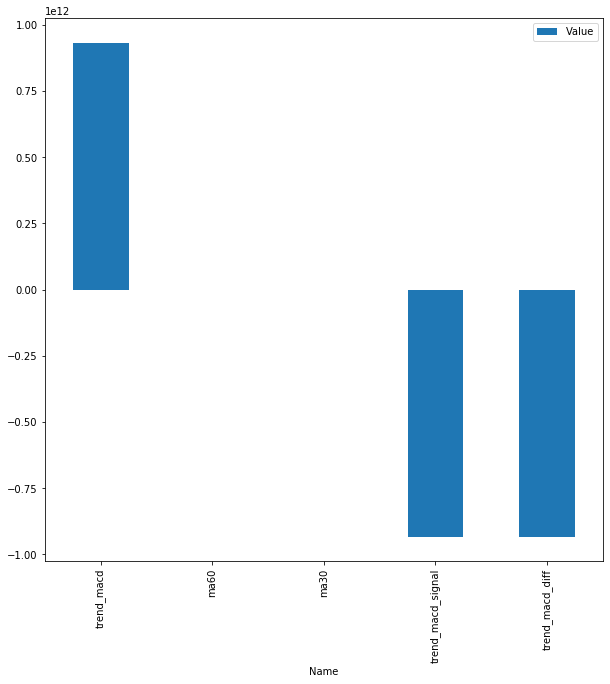

In [66]:
result_df.sort_values('Value', ascending=False).plot(figsize = (10,10), kind='bar',x='Name',y='Value')

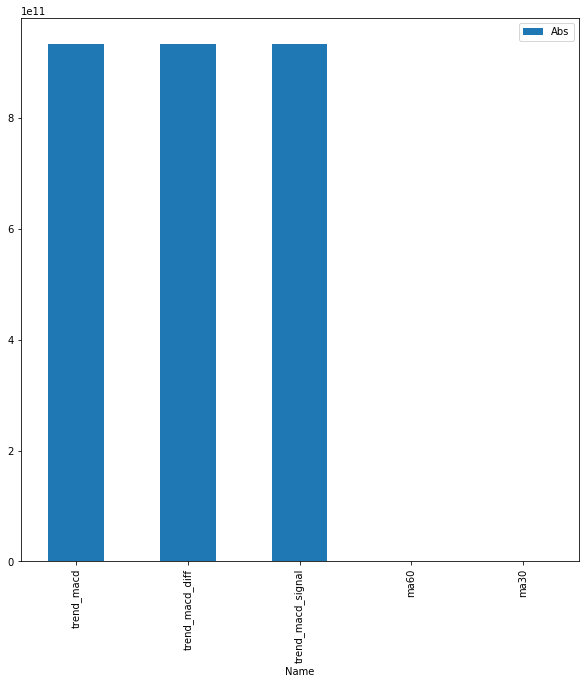

In [67]:
result_df.sort_values('Abs', ascending=False).plot(figsize = (10,10), kind='bar',x='Name',y='Abs')

[ 25  67 106 169] [0.01057397 0.00174161 0.00844498 0.07052915]
[ 48  70 122 325] [0.01057397 0.00174161 0.00844498 0.0269437 ]


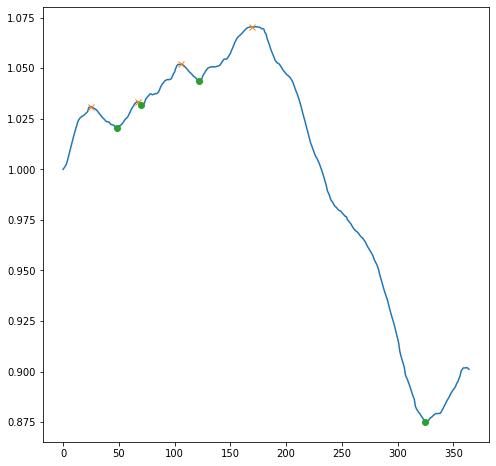

In [159]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# x = (df.ma60[-1000:]/list(df.ma60[-1000:])[0]).reset_index(drop = True)
x = (df.ma60[:365]/df.ma60[:365][0]).reset_index(drop = True)

peaks, pp = find_peaks(x, prominence=0.001)
troughs, tp = find_peaks(-1*x, prominence=0.001)

print(peaks, pp['prominences'])
print(troughs, tp['prominences'])

plt.figure(figsize=(8,8))
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(troughs, x[troughs], "o")

# plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [53]:
for i, df in enumerate(df_list):
    df_list[i]['trend_macd'] = ta.trend.macd(df['Price'])
    df_list[i]['trend_macd_diff'] = ta.trend.macd_diff(df['Price'])
    df_list[i]['trend_macd_signal'] = ta.trend.macd_signal(df['Price'])

In [171]:
np.isin(df.index.values, peaks).astype(int) * -1

array([0, 0, 0, ..., 0, 0, 0])

In [54]:
def get_afternan(foo):
    afternan = np.where(np.isnan(foo))[0][-1] + 1
    return afternan

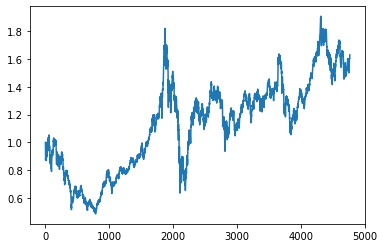

In [60]:
plt.plot(df_list[2]['Price']/df_list[2]['Price'][0])
# plt.plot(df_list[0]['trend_macd']/df_list[0]['trend_macd'][get_afternan(df_list[0]['trend_macd'])])
# plt.plot(df_list[0]['trend_macd_diff'])
# plt.plot(df_list[0]['trend_macd_signal'])

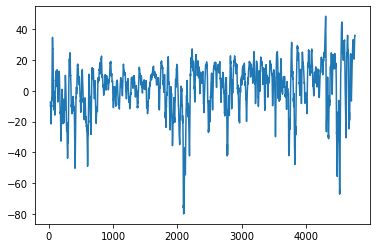

In [61]:
plt.plot(df_list[0]['trend_macd'])

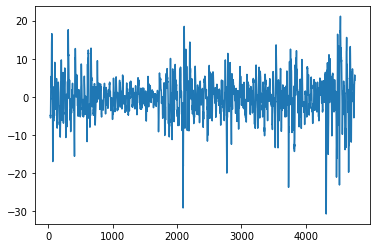

In [62]:
plt.plot(df_list[0]['trend_macd_diff'])

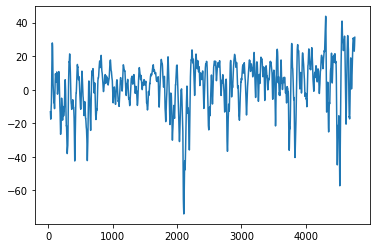

In [63]:
plt.plot(df_list[0]['trend_macd_signal'])